<a href="https://colab.research.google.com/github/alessandrotofani/Tesi_magistrale/blob/master/3_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
from google.colab import drive
drive.mount('/content/drive')
from sklearn.model_selection import train_test_split

Mounted at /content/drive


In [2]:
import sys 
sys.path.append('/content/drive/MyDrive/Tesi_magistrale/Tesi_magistrale')
import mf

#  Feature scaling

In [3]:
if not os.path.isfile('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/corr_data.csv'):
  correlation_data = min_max_scaling(correlation_data)
  correlation_data.to_csv(r'./corr_data.csv')

if not os.path.isfile('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/data.csv'):
  correlation_data = pd.read_csv('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/corr_data.csv')

In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # serve per ignorare i FutureWarning

Rimpiazzo i missing values in categorical data con unknown. 

Unisco i dataset numerici e categorici nel dataframe data. 

Riferimento fillna: https://jamesrledoux.com/code/imputation

In [5]:
if not os.path.isfile('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/data.csv'):
  col_to_drop = col_not_sign(categorical_data, cat_sign_col)
  categorical_data = categorical_data.drop(col_to_drop, axis=1)
  categorical_data = categorical_data.fillna('unknown')
  data = pd.merge(correlation_data, categorical_data, left_on='TransactionID', right_on='TransactionID', how='left')
  del correlation_data, categorical_data, numerical_data
  data.to_csv(r'./data.csv')

data = pd.read_csv('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/data.csv')
data.drop(data.columns[data.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
data = mf.feature_scaling(data)

# Feature engineering

In [6]:
data = mf.feature_engineering(data)

# One hot encoding

One hot encoding delle features categoriche. Serve per lo smote e easy ensemble. 

Bisogna farlo prima dello split del dataset poichè rischio di perdere delle colonne. 

In [7]:
data = pd.get_dummies(data)

In [8]:
cols = mf.get_col(data)

Seleziono i dati appartenenti ai primi 60 giorni. 

Se ne seleziono di più, l'easy ensemble non va. 

In [9]:
# data = mf.select_days(data, 60)

Splitto il dataset in train, validation e test set. 

In [10]:
X_train, X_val, y_train, y_val = mf.split(data, test_size = 0.2)
del data
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [11]:
save_id = True 

if save_id:
  train_id = X_train.index.tolist()
  val_id = X_val.index.tolist()
  test_id = X_test.index.tolist()
  mf.save_list('train_id',train_id)
  mf.save_list('val_id', val_id)
  mf.save_list('test_id', test_id)

load_id = False 
if load_id:
  mf.load_list('train_id',train_id)
  mf.load_list('val_id', val_id)
  mf.load_list('test_id', test_id)

# Undersampling: Easy Ensemble

L'easy ensemble tramite un metodo unsupervised divide il dataset in diversi dataset undersampled. 

Documentazione easy ensemble: http://glemaitre.github.io/imbalanced-learn/generated/imblearn.ensemble.EasyEnsemble.html#imblearn.ensemble.EasyEnsemble

Esempio applicazio ee: http://glemaitre.github.io/imbalanced-learn/auto_examples/ensemble/plot_easy_ensemble.html?highlight=easy%20ensemble

In [12]:
# X_trainres, y_trainres = mf.easy_ensemble(5, X_train, y_train)

In [13]:
# X_trainres_df = pd.DataFrame(data = X_trainres[0], columns = cols)
# del X_trainres

# XGBoost

ROC curve: https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_roc_curve_visualization_api.html#sphx-glr-auto-examples-miscellaneous-plot-roc-curve-visualization-api-py

XGBoost: https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

gpu_hist method: https://xgboost.readthedocs.io/en/latest/parameter.html#additional-parameters-for-hist-and-gpu-hist-tree-method

## Load model

Riferimento: https://xgboost.readthedocs.io/en/latest/python/python_intro.html

In [14]:
load = False
if load:
  from joblib import load
  from xgboost import XGBClassifier

  clf = load("/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/xgboost/xgb.joblib.dat")

## Training

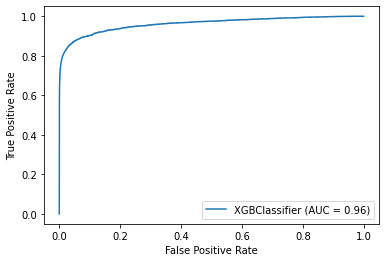

In [15]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.datasets import make_classification
from sklearn.metrics import plot_roc_curve
from xgboost import XGBClassifier

if not load:
  clf = XGBClassifier(n_estimators = 4000, max_depth = 10, 
                      objective='binary:logistic', learning_rate = 0.5, 
                      tree_method='gpu_hist') 
  
  clf.fit(X_train, y_train)

plot_roc_curve(clf, X_val, y_val)
plt.show()

# Save model

In [19]:
from joblib import dump
dump(clf, "xgb.joblib.dat")

['xgb.joblib.dat']

# Perfomance evaluation

## Confusion matrix

[[113697    156]
 [  1372   2882]]


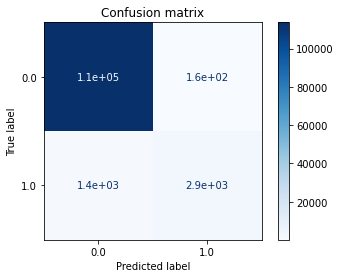

In [ ]:
mf.conf_matrix(clf, X_val, y_val)

## Mean average precision

AP max = 0.84

AP: https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#sphx-glr-auto-examples-model-selection-plot-precision-recall-py

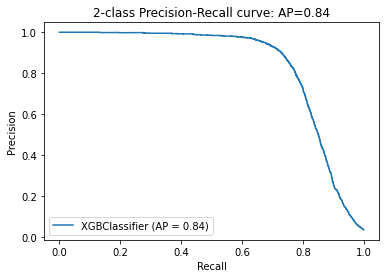

In [ ]:
mf.ap_metric(clf, X_val, y_val, proba = True)

## Feature importance

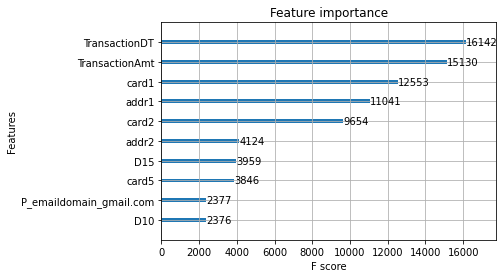

In [ ]:
import xgboost as xgb
xgb.plot_importance(clf, max_num_features = 10)